In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from joblib import Parallel, delayed

# memory tracker

In [2]:
import tracemalloc
import time
import sys

# Start tracing memory allocations
# tracemalloc.start()

# Function to display memory usage for a specific variable
def memory_usage_snapshot(var_name, variable):
    current, peak = tracemalloc.get_traced_memory()
    print(f"Snapshot - Variable: {var_name}")
    print(f"    Current memory usage: {current / (1024 ** 2):.2f} MB")
    print(f"    Peak memory usage: {peak / (1024 ** 2):.2f} MB")
    print(f"    Size of {var_name}: {sys.getsizeof(variable) / (1024 ** 2):.2f} MB")

# tracemalloc.stop()


#  V_A change

In [3]:
base_V_A = 1
dt = 1e-4

def V_A_change(t, slope, base_V_A):
    return base_V_A + slope * t

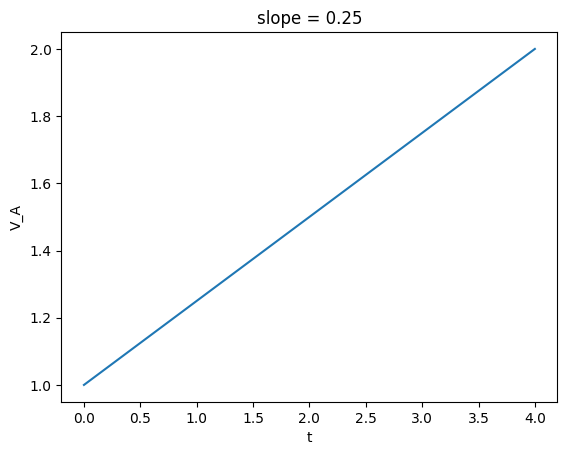

In [4]:
t_pts = np.arange(0, 4, dt)
slope = 0.25
V_A_pts = V_A_change(t_pts, slope, base_V_A)

plt.plot(t_pts, V_A_pts)
plt.title(f'slope = {slope}')
plt.xlabel('t')
plt.ylabel('V_A');

# get LED times

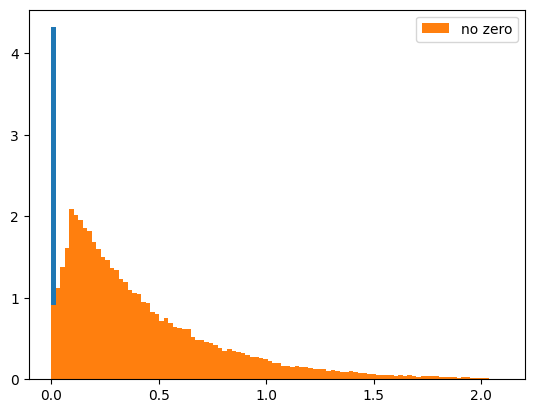

In [5]:
og_df = pd.read_csv('../out_LED.csv')
df = og_df[ og_df['repeat_trial'].isin([0,2]) | og_df['repeat_trial'].isna() ]
session_type = 7    
df = df[ df['session_type'].isin([session_type]) ]
training_level = 16
df = df[ df['training_level'].isin([training_level]) ]

# t_stim_and_led_tuple = [(row['intended_fix'], row['LED_onset_time']) for _, row in df.iterrows()]

LED_times = (df['intended_fix'] - df['LED_onset_time']).values
plt.hist(LED_times, bins=100, density=True);

# remove zero from LED_times
LED_times = LED_times[LED_times != 0]
plt.hist(LED_times, bins=100, density=True, label='no zero');

plt.legend();


# simulator

In [6]:
dt = 1e-3; dB = np.sqrt(dt)

def proactive_V_A_change_simulate(base_V_A, theta_A, slope):
    DV = 0
    t = 0
    LED_onset_time = np.random.choice(LED_times)
    while True:
        if t <= LED_onset_time:
            v = base_V_A
        else:
            v = base_V_A + slope * (t - LED_onset_time)
        
        DV += v*dt + np.random.normal(0, dB)
        t += dt

        if DV >= theta_A:
            return t, LED_onset_time, ( base_V_A, theta_A, slope )
        

# check simulated data

In [7]:
# ---- PARAMS  ---
base_V_A = 1
theta_A = 2
slope = 0.25

In [8]:

# N_sim = int(25e3)
# sim_results = Parallel(n_jobs=-1)(delayed(proactive_V_A_change_simulate)(base_V_A, theta_A, slope) for _ in range(N_sim))
# plt.hist([t for t, _, _ in sim_results], bins=100, density=True, alpha=0.5, label='sim')
# plt.legend();

# SBI

In [9]:
import torch
from sbi.inference import SNLE

In [10]:
tracemalloc.start()

N = int(500e3)

# theta
base_V_A_distr = torch.distributions.Uniform(0.1, 5.0).sample((N,))
theta_A_distr = torch.distributions.Uniform(0.1, 5.0).sample((N,))
slope_distr = torch.distributions.Uniform(0.1, 1.0).sample((N,))

sim_results = Parallel(n_jobs=-1)(delayed(proactive_V_A_change_simulate)(base_V_A.item(), theta_A.item(), slope.item()) \
                                   for base_V_A, theta_A, slope in zip(base_V_A_distr, theta_A_distr, slope_distr))

memory_usage_snapshot('sim_results', sim_results)

tracemalloc.stop()

Snapshot - Variable: sim_results
    Current memory usage: 122.77 MB
    Peak memory usage: 250.88 MB
    Size of sim_results: 3.97 MB


In [11]:
rts = torch.tensor([t for t, _, _ in sim_results]).reshape(-1, 1)
params = torch.tensor([[param[0], param[1], param[2], LED_time] for _, LED_time, param in sim_results]).reshape(-1, 4)

rts = rts.to(dtype=torch.float32)
params = params.to(dtype=torch.float32)

print(rts.shape, params.shape)



torch.Size([500000, 1]) torch.Size([500000, 4])


In [12]:
tracemalloc.start()
inference = SNLE(density_estimator='nsf')
likelihood_estimator = inference.append_simulations(params, rts).train()

memory_usage_snapshot('likelihood_estimator', likelihood_estimator)
tracemalloc.stop()

/home/rka/code/ddm_data/venv/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


 Neural network successfully converged after 67 epochs.Snapshot - Variable: likelihood_estimator
    Current memory usage: 53.31 MB
    Peak memory usage: 108.12 MB
    Size of likelihood_estimator: 0.00 MB


## test snle

In [13]:
N_sim_2 = int(50e3)
gen_data = Parallel(n_jobs=-1)(delayed(proactive_V_A_change_simulate)(base_V_A, theta_A, slope) for _ in range(int(N_sim_2)))
gen_data_rt = [t for t, _, _ in gen_data]
gen_data_led = [led_time for _, led_time, _ in gen_data]

(10000,)


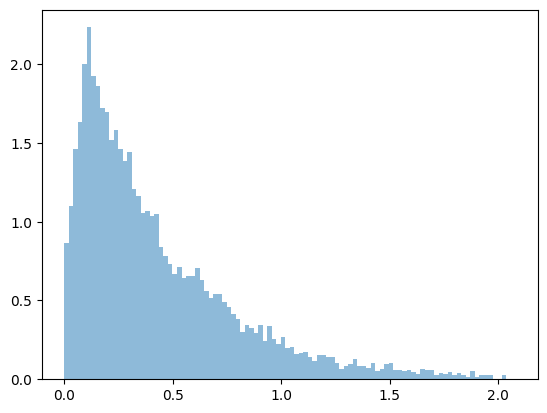

In [14]:
gen_data_led_unique = np.unique(LED_times)
# sample 1000 unique led times
gen_data_led_unique = np.random.choice(gen_data_led_unique, 10000)

print(gen_data_led_unique.shape)
plt.hist(gen_data_led_unique, bins=100, density=True, alpha=0.5, label='gen');


In [15]:
tracemalloc.start()
N_test = 1000
x_test = torch.linspace(0,5, N_test).reshape(1, -1)

led_weight_likelihood = torch.zeros((len(gen_data_led_unique), N_test))
print(f'led_weight_likelihood.shape: {led_weight_likelihood.shape}')
from tqdm import tqdm

for i, LED_t in tqdm(enumerate(gen_data_led_unique), total=len(gen_data_led_unique)):
    theta_test = torch.tensor([base_V_A, theta_A, slope, LED_t]).repeat(N_test, 1).to(dtype=torch.float32)
    loglike = likelihood_estimator.log_prob(x_test, theta_test)

    like = torch.exp(loglike)
    # led_mask = (x_test < LED_t).to(dtype=torch.float32)

    # like_x_led_mask = like * led_mask
    led_weight_likelihood[i,:] = like


memory_usage_snapshot('led_weight_likelihood', led_weight_likelihood)

tracemalloc.stop()

led_weight_likelihood.shape: torch.Size([10000, 1000])


100%|██████████| 10000/10000 [01:01<00:00, 163.02it/s]

Snapshot - Variable: led_weight_likelihood
    Current memory usage: 153.49 MB
    Peak memory usage: 153.50 MB
    Size of led_weight_likelihood: 0.00 MB


In [16]:
print(led_weight_likelihood.shape)
led_weight_likelihood_mean = led_weight_likelihood.mean(dim=0)
print(led_weight_likelihood_mean.shape)

torch.Size([10000, 1000])
torch.Size([1000])


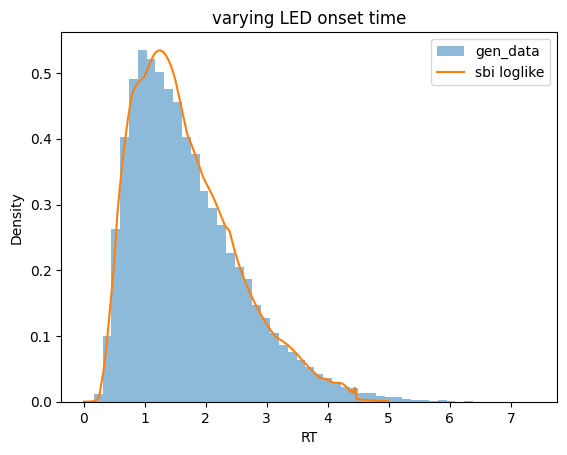

In [17]:
plt.hist(gen_data_rt, bins=50, density=True, alpha=0.5, label='gen_data');
plt.plot(x_test.squeeze().detach(), led_weight_likelihood_mean.detach(), label='sbi loglike')
plt.title('varying LED onset time')
plt.legend();
plt.xlabel('RT')
plt.ylabel('Density');

In [ ]:
import sys
import pandas as pd

# Get all variables in the current scope
all_variables = {name: sys.getsizeof(value) for name, value in globals().items()}

# Convert to a DataFrame for sorting and better presentation
variables_df = pd.DataFrame(all_variables.items(), columns=['Variable', 'Size (bytes)'])

# Add columns for size in MB and GB
variables_df['Size (MB)'] = variables_df['Size (bytes)'] / (1024 ** 2)
variables_df['Size (GB)'] = variables_df['Size (bytes)'] / (1024 ** 3)

# Sort the variables by size in descending order
variables_df = variables_df.sort_values(by='Size (bytes)', ascending=False).reset_index(drop=True)

# Display the result
print(variables_df[['Variable', 'Size (MB)']])

import sys

# Get all variables in the current scope and their sizes
total_size_bytes = sum(sys.getsizeof(value) for value in globals().values())

# Convert to MB and GB
total_size_mb = total_size_bytes / (1024 ** 2)
total_size_gb = total_size_bytes / (1024 ** 3)

print(f"Total RAM occupied: {total_size_bytes} bytes")
print(f"Total RAM occupied: {total_size_mb:.2f} MB")
print(f"Total RAM occupied: {total_size_gb:.2f} GB")



In [ ]:
import psutil
import os

# Get the current process
process = psutil.Process(os.getpid())

# Get memory usage in bytes, then convert to MB and GB
memory_info = process.memory_info()
ram_used_bytes = memory_info.rss  # Resident Set Size: Memory the process is using
ram_used_mb = ram_used_bytes / (1024 ** 2)
ram_used_gb = ram_used_bytes / (1024 ** 3)

print(f"RAM used by the program: {ram_used_bytes} bytes")
print(f"RAM used by the program: {ram_used_mb:.2f} MB")
print(f"RAM used by the program: {ram_used_gb:.2f} GB")
